In [1]:
import pandas as pd
df = pd.read_csv('gas_demand_test.csv')

display(df.shape)
display(df.head())
display(df.dtypes)
display(df.isnull().any())


(206, 2)

,TIME,European Union - 27 countries (from 2020)
0,2008-01,2012060
1,2008-02,1754306
2,2008-03,1736092
3,2008-04,1372621
4,2008-05,1041214


TIME                                         object
European Union - 27 countries (from 2020)    object
dtype: object

TIME                                         False
European Union - 27 countries (from 2020)    False
dtype: bool

In [2]:
df = df.rename(columns = {'TIME':'date', 'European Union - 27 countries (from 2020)': 'data'})

df['data'] = df['data'].replace(':', None)
df['data'] = pd.to_numeric(df['data'])
df['data'] = df['data'].ffill()

df = df.groupby(by='date').agg({'data': 'sum'})
df.index = pd.to_datetime(df.index)
df


,data
date,
2008-01-01,2012060.000
2008-02-01,1754306.000
2008-03-01,1736092.000
2008-04-01,1372621.000
2008-05-01,1041214.000
...,...
2024-10-01,940354.976
2024-11-01,1417925.066
2024-12-01,1643133.040


In [3]:
date = '2023-01-1'
df_train = df.loc[:date]
df_test = df.loc[date:]

print(f'Training set: {len(df_train)}')
print(f'Test set: {len(df_test)}')

Training set: 181
Test set: 26


,data
date,
2008-01-01,2012060.0
2008-02-01,1754306.0
2008-03-01,1736092.0
2008-04-01,1372621.0
2008-05-01,1041214.0


Augmneted Dickey_fuller Statistic: -1.741366
p-value: 0.409935


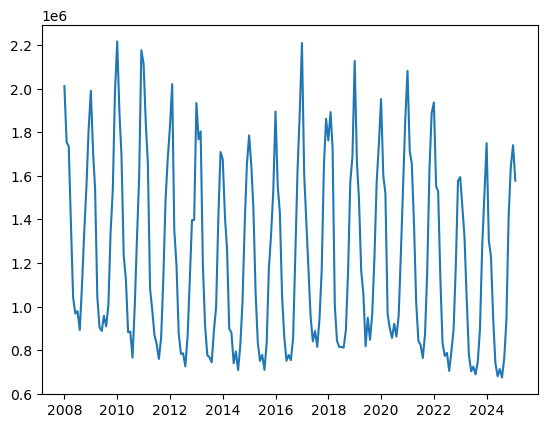

In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
df = df.sort_index(ascending=True)

display(df.head())

res = adfuller(df['data'])

# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

plt.plot(df['data'])
plt.show()

,data
date,
2008-02-01,-257754.0
2008-03-01,-18214.0
2008-04-01,-363471.0
2008-05-01,-331407.0
2008-06-01,-73255.0
2008-07-01,11218.0
2008-08-01,-86594.0
2008-09-01,207759.0
2008-10-01,237770.0


Augmneted Dickey_fuller Statistic: -5.011453
p-value: 0.000021


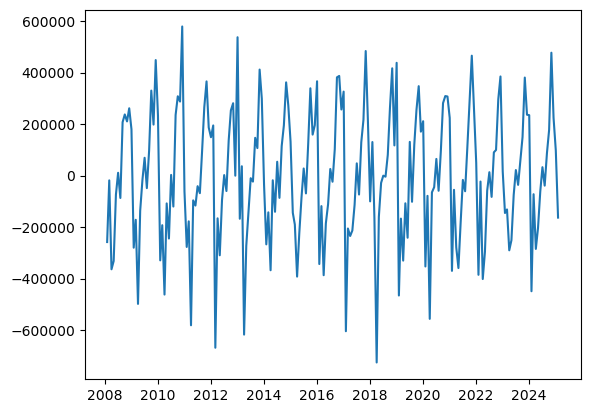

In [5]:
data_diff_1 = df.diff().dropna()

display(data_diff_1.head(10))

res = adfuller(data_diff_1['data'])
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

plt.plot(data_diff_1['data'])
plt.show()


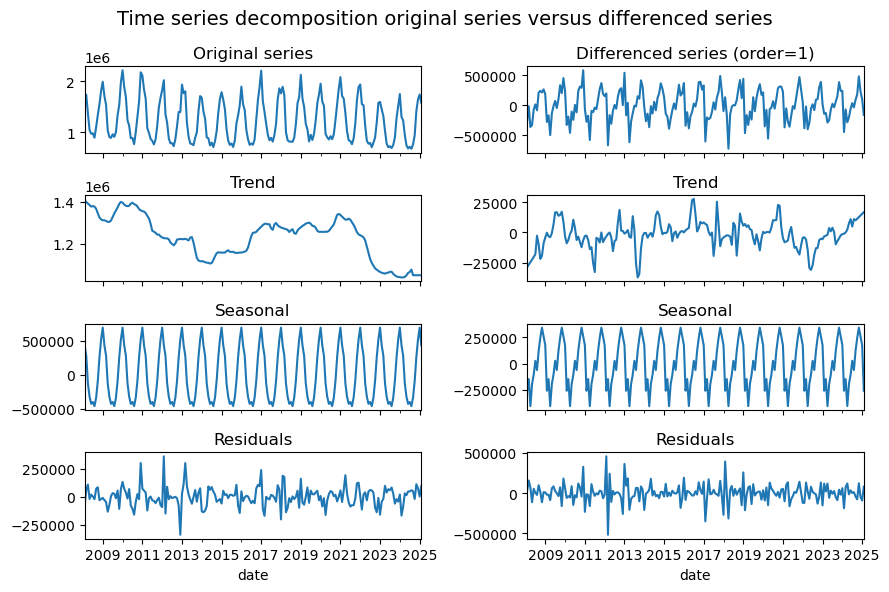

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

res_decompose = seasonal_decompose(df, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time series decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

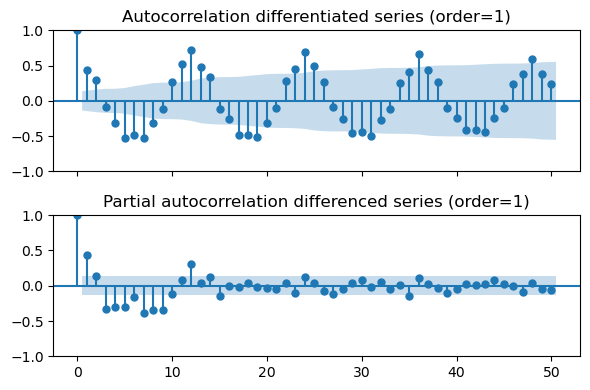

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data_diff_1, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation differentiated series (order=1)');
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout()

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('once')


warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = df_train, order = (1, 1, 2), seasonal_order = (1, 1, 2, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")
model_res.summary()

c:\Users\benja\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               data   No. Observations:                  181
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -2237.253
Date:                            Mon, 28 Apr 2025   AIC                           4488.505
Time:                                    22:15:01   BIC                           4510.373
Sample:                                01-01-2008   HQIC                          4497.380
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9373      0.078    -12.037      0.000      -1.090      -0.785
ma.L1          0.7184      0.120      5.981      0.000       0.483       0.954
ma.L2         -0.2627      0.057     -4.594      0.000      -0.375      -0.151
ar.S.L12       0.0665      0.304      0.219      0.827      -0.530       0.663
ma.S.L12      -0.6811      0.313     -2.173      0.030      -1.295      -0.067
ma.S.L24      -0.0843      0.208     -0.404      0.686      -0.493       0.324
sigma2       2.55e+10    1.5e-11   1.69e+21      0.000    2.55e+10    2.55e+10
===================================================================================
Ljung-Box (L1) (Q):                   2.27   Jarque-Bera (JB):                14.80
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.13e+36. Standard errors may be unstable.
"""

In [9]:
predictions_statsmodels = model_res.get_forecast(steps=len(df_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(4))

2023-02-01    1.294287e+06
2023-03-01    1.208102e+06
2023-04-01    7.939501e+05
2023-05-01    5.729693e+05
Freq: MS, Name: predictions_statsmodels, dtype: float64

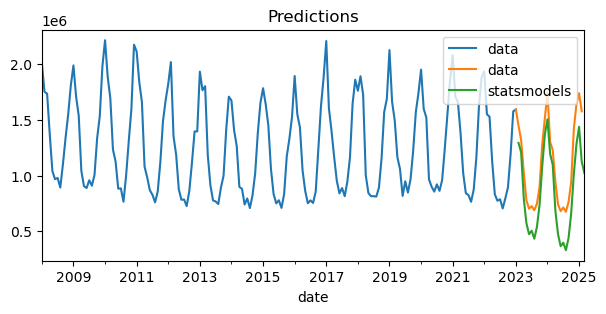

In [10]:
fig, ax = plt.subplots(figsize=(7, 3))
df_train.plot(ax=ax, label='training')
df_test.plot(ax=ax, label='testing')
predictions_statsmodels.plot(ax=ax, label='statsmodels')
ax.set_title('Predictions')
ax.legend();